In [20]:
# 1. Import Libraries and Configure Environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import torch
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import re
from collections import Counter

# Configure Plotting
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Check for GPU
device = 0 if torch.cuda.is_available() else -1
if torch.backends.mps.is_available():
    device = "mps"
print(f"Using device: {device}")

Using device: 0


In [21]:
# 2. Load Data and Preprocess Lyrics

# Download/Load Dataset
print("Loading dataset...")
path = kagglehub.dataset_download("rhaamrozenberg/billboards-top-100-song-1946-to-2022-lyrics")
print("Path to dataset files:", path)
# Load CSV
import os
import ast
csv_path = os.path.join(path, "Billboard_Hot_100_with_features.csv") # Verify filename if possible, usually it's this or similar

if not os.path.exists(csv_path):
    files = os.listdir(path)
    csv_files = [f for f in files if f.endswith('.csv')]
    if csv_files:
        csv_path = os.path.join(path, csv_files[0])
    else:
        raise FileNotFoundError("No CSV found in dataset path")

df = pd.read_csv(csv_path)
print(f"Loaded {len(df)} rows.")
print("Original Columns:", df.columns)

# Rename columns for consistency
# Actual columns: ['Song', 'Artist Names', 'Hot100 Ranking Year', 'Hot100 Rank', 'Lyrics']
rename_map = {
    'Hot100 Ranking Year': 'year',
    'Hot100 Rank': 'rank',
    'Lyrics': 'lyrics',
    'Song': 'title',
    'Artist Names': 'artist'
}
df.rename(columns=rename_map, inplace=True)
print("Renamed Columns:", df.columns)

# Ensure numeric types
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df['rank'] = pd.to_numeric(df['rank'], errors='coerce')

# Basic Preprocessing
# 1. Convert 'year' to numeric if needed (it usually is)
# 2. Clean lyrics
def clean_lyrics(text):
    if not isinstance(text, str):
        return ""
    
    # The lyrics seem to be string representations of lists: "['word', 'word', ...]"
    # We need to parse this string back into a list and join it, or just clean the string representation.
    # Let's try to parse it safely.
    try:
        # If it looks like a list string "['...']"
        if text.strip().startswith('[') and text.strip().endswith(']'):
            # Use ast.literal_eval to safely parse the string list
            words = ast.literal_eval(text)
            if isinstance(words, list):
                text = ' '.join(words)
    except (ValueError, SyntaxError):
        # If parsing fails, fall back to regex cleaning of the string representation
        pass

    text = text.lower()
    # Remove text in brackets like [Chorus], [Verse 1] (if any remain after joining)
    text = re.sub(r'\[.*?\]', '', text)
    # Remove special characters but keep basic punctuation if needed, or strip all
    text = re.sub(r'[^a-z0-9\s\.,\'\?!]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning
print("Cleaning lyrics...")
df['lyrics_clean'] = df['lyrics'].apply(clean_lyrics)

# Debug: Check lengths
print("Lyrics length stats:", df['lyrics_clean'].str.len().describe())

# Filter empty lyrics
before_len = len(df)
df = df[df['lyrics_clean'].str.len() > 50]
print(f"Rows after lyrics length filter: {len(df)} (dropped {before_len - len(df)})")

# Filter Year Window (2000-2023 is the dataset, but let's ensure)
before_len = len(df)
df = df[(df['year'] >= 2000) & (df['year'] <= 2023)]
print(f"Rows after year filter: {len(df)} (dropped {before_len - len(df)})")

# Sort
df = df.sort_values(['year', 'rank'])

print(f"Final dataset size: {len(df)}")
if len(df) > 0:
    print(df.head())
else:
    print("WARNING: Dataset is empty after filtering. Check year range and lyrics content.")

Loading dataset...
Path to dataset files: /home/ucloud/.cache/kagglehub/datasets/rhaamrozenberg/billboards-top-100-song-1946-to-2022-lyrics/versions/1
Loaded 6879 rows.
Original Columns: Index(['Song', 'Artist Names', 'Hot100 Ranking Year', 'Hot100 Rank', 'Lyrics'], dtype='object')
Renamed Columns: Index(['title', 'artist', 'year', 'rank', 'lyrics'], dtype='object')
Cleaning lyrics...
Lyrics length stats: count    6879.000000
mean     1399.715075
std       943.656294
min         0.000000
25%       819.500000
50%      1293.000000
75%      1863.000000
max      6036.000000
Name: lyrics_clean, dtype: float64
Rows after lyrics length filter: 6029 (dropped 850)
Rows after year filter: 2134 (dropped 3895)
Final dataset size: 2134
                                    title                          artist  \
4585                              Breathe                  ['faith hill']   
4586            Smooth (feat. Rob Thomas)       ['santana', 'rob thomas']   
4587  Maria Maria (feat. The Product

In [22]:
# 3. Extract Sentiment and Emotion Features

# Initialize Sentiment Pipeline (RoBERTa)
print("Initializing Sentiment Model...")
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    tokenizer="cardiffnlp/twitter-roberta-base-sentiment-latest",
    device=0 if device == 0 else -1, # MPS support in transformers pipelines can be tricky, usually CPU or CUDA
    top_k=None # Return all scores
)

# Initialize Emotion Pipeline (GoEmotions)
print("Initializing Emotion Model...")
emotion_pipeline = pipeline(
    "text-classification",
    model="SamLowe/roberta-base-go_emotions",
    device=0 if device == 0 else -1,
    top_k=None
)

# Function to process in batches
def get_sentiment_emotion(texts, batch_size=32):
    sentiments = []
    emotions = []
    
    # Process sentiment
    print("Processing Sentiment...")
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        # Enable truncation to prevent CUDA errors on long lyrics
        results = sentiment_pipeline(batch, truncation=True, max_length=512)
        # results is list of lists of dicts
        for res in results:
            # res is [{'label': 'positive', 'score': 0.9}, ...]
            scores = {item['label']: item['score'] for item in res}
            # Calculate valence score: Positive - Negative
            valence = scores.get('positive', 0) - scores.get('negative', 0)
            sentiments.append(valence)
            
    # Process emotions
    print("Processing Emotions...")
    # We'll focus on key emotions: sadness, anxiety (fear), anger, joy
    target_emotions = ['sadness', 'fear', 'anger', 'joy', 'optimism', 'excitement']
    
    emotion_data = {e: [] for e in target_emotions}
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        results = emotion_pipeline(batch, truncation=True, max_length=512)
        
        for res in results:
            scores = {item['label']: item['score'] for item in res}
            for e in target_emotions:
                emotion_data[e].append(scores.get(e, 0))
                
    return sentiments, emotion_data

# Run extraction
# Using a sample for speed if needed, but let's try full dataset (approx 2300 songs)
texts = df['lyrics_clean'].tolist()
print(f"Extracting features for {len(texts)} songs...")

# Note: This might take a few minutes.
valences, emotion_scores = get_sentiment_emotion(texts)

# Add to DataFrame
df['valence_transformer'] = valences
for e, scores in emotion_scores.items():
    df[f'emotion_{e}'] = scores

print("Feature extraction complete.")
df.head()

Initializing Sentiment Model...


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


Initializing Emotion Model...


Device set to use cuda:0


Extracting features for 2134 songs...
Processing Sentiment...
Processing Emotions...
Feature extraction complete.


,title,artist,year,rank,lyrics,lyrics_clean,valence_transformer,emotion_sadness,emotion_fear,emotion_anger,emotion_joy,emotion_optimism,emotion_excitement
4585,Breathe,['faith hill'],2000,1,"['i', 'can', 'feel', 'the', 'magic', 'floating...",i can feel the magic floating in the air being...,0.801516,0.003852,0.001518,0.000732,0.051753,0.007175,0.029381
4586,Smooth (feat. Rob Thomas),"['santana', 'rob thomas']",2000,2,"['man', 'its', 'a', 'hot', 'one', 'like', 'sev...",man its a hot one like seven inches from the m...,0.746646,0.005268,0.000895,0.001901,0.004733,0.032217,0.002061
4587,Maria Maria (feat. The Product G&B),"['santana', 'the product g b']",2000,3,"['ladies', 'and', 'gents', 'turn', 'up', 'your...",ladies and gents turn up your sound system to ...,0.305210,0.009018,0.001966,0.001799,0.014647,0.004106,0.013464
4588,I Wanna Know,['joe'],2000,4,"['yeah', 'oh', 'yeah', 'alright', 'oh', 'oh', ...",yeah oh yeah alright oh oh oh its amazing how ...,0.747759,0.028555,0.003844,0.008411,0.003364,0.022576,0.012821
4589,Everything You Want,['vertical horizon'],2000,5,"['somewhere', 'theres', 'speaking', 'its', 'al...",somewhere theres speaking its already coming i...,-0.167708,0.006914,0.001178,0.004268,0.000649,0.012880,0.000370


In [23]:
# 4. Extract Lexical and Economic Dictionary Features

# Define Lexicons
economic_lexicon = set([
    'money', 'broke', 'job', 'work', 'bills', 'rent', 'debt', 'pay', 'paycheck', 
    'mortgage', 'bank', 'rich', 'poor', 'cash', 'dollar', 'price', 'cost', 'economy',
    'crisis', 'recession', 'hustle', 'grind', 'wage', 'saving', 'spend'
])

pronouns_first = set(['i', 'me', 'my', 'mine', 'myself'])
pronouns_social = set(['we', 'us', 'our', 'ours', 'ourselves'])
negations = set(['not', 'never', 'no', 'cant', 'wont', 'dont', 'didnt', 'couldnt', 'wouldnt', 'shouldnt'])

def extract_lexical_features(text):
    words = text.split()
    num_words = len(words)
    if num_words == 0:
        return pd.Series([0]*6)
    
    # Counts
    econ_count = sum(1 for w in words if w in economic_lexicon)
    first_person_count = sum(1 for w in words if w in pronouns_first)
    social_count = sum(1 for w in words if w in pronouns_social)
    negation_count = sum(1 for w in words if w in negations)
    
    # Type-Token Ratio
    ttr = len(set(words)) / num_words
    
    # Avg Word Length
    avg_len = sum(len(w) for w in words) / num_words
    
    return pd.Series([
        econ_count / num_words, # Normalize by length
        first_person_count / num_words,
        social_count / num_words,
        negation_count / num_words,
        ttr,
        avg_len
    ])

print("Extracting lexical features...")
lexical_cols = ['freq_economic', 'freq_self', 'freq_social', 'freq_negation', 'ttr', 'avg_word_len']
df[lexical_cols] = df['lyrics_clean'].apply(extract_lexical_features)

print("Lexical extraction complete.")
df[lexical_cols].describe()

Extracting lexical features...
Lexical extraction complete.


,freq_economic,freq_self,freq_social,freq_negation,ttr,avg_word_len
count,2134.000000,2134.000000,2134.000000,2134.000000,2134.000000,2134.000000
mean,0.002975,0.076458,0.008733,0.024337,0.309525,3.718813
std,0.008904,0.038600,0.014623,0.021497,0.074973,0.256557
min,0.000000,0.000000,0.000000,0.000000,0.071307,2.741197
25%,0.000000,0.049163,0.000000,0.009709,0.256790,3.561086
50%,0.000000,0.073416,0.003578,0.018764,0.306692,3.695106
75%,0.002770,0.101351,0.010762,0.031852,0.356926,3.846291
max,0.221461,0.238095,0.177586,0.177083,0.698718,5.706383


In [24]:
# 5. Compute Semantic Similarity to Recession Concepts

# Initialize Sentence Transformer
# 'all-mpnet-base-v2' is a strong general-purpose model
EMBEDDING_MODEL = "sentence-transformers/all-mpnet-base-v2"
print(f"Loading Embedding model: {EMBEDDING_MODEL}")
embedder = SentenceTransformer(EMBEDDING_MODEL, device=device if device != -1 else 'cpu')

# Define rich concept descriptions
concepts = {
    "econ_anxiety": "lyrics about losing jobs, struggling to pay bills, being broke, worrying about money, recession, crisis",
    "resilience": "working overtime, hustling to survive, keeping family afloat, working multiple jobs",
    "escapist_party": "forgetting problems by partying, drinking, getting high to escape real life",
    "luxury_flex": "bragging about money, expensive cars, brands, being rich"
}

# Encode the concept descriptions
print("Encoding concept descriptions...")
concept_embeddings = {name: embedder.encode(desc, convert_to_tensor=True) for name, desc in concepts.items()}

# Encode lyrics
print(f"Encoding lyrics for {len(df)} songs...")
lyrics_list = df['lyrics_clean'].tolist()
# Batch encoding
lyric_embeddings = embedder.encode(lyrics_list, batch_size=64, convert_to_tensor=True, show_progress_bar=True)

# Compute cosine similarities
print("Computing similarities...")
similarity_scores = {}

for name, concept_emb in concept_embeddings.items():
    # util.cos_sim returns (1, N)
    scores = util.cos_sim(concept_emb, lyric_embeddings)[0]
    similarity_scores[f'sim_{name}'] = scores.cpu().numpy()

# Add to dataframe
for name, scores in similarity_scores.items():
    df[name] = scores

print("Semantic similarity computation complete.")
df[['sim_econ_anxiety', 'sim_resilience', 'sim_escapist_party', 'sim_luxury_flex']].head()

Loading Embedding model: sentence-transformers/all-mpnet-base-v2
Encoding concept descriptions...
Encoding lyrics for 2134 songs...


Batches:   0%|          | 0/34 [00:00<?, ?it/s]

Computing similarities...
Semantic similarity computation complete.


,sim_econ_anxiety,sim_resilience,sim_escapist_party,sim_luxury_flex
4585,0.288504,-0.011410,0.002311,0.008849
4586,0.344478,0.005149,0.024766,0.027101
4587,0.434963,0.082124,0.043941,0.040656
4588,0.264591,-0.049333,-0.028831,0.037315
4589,0.334899,-0.028240,0.118427,0.047501


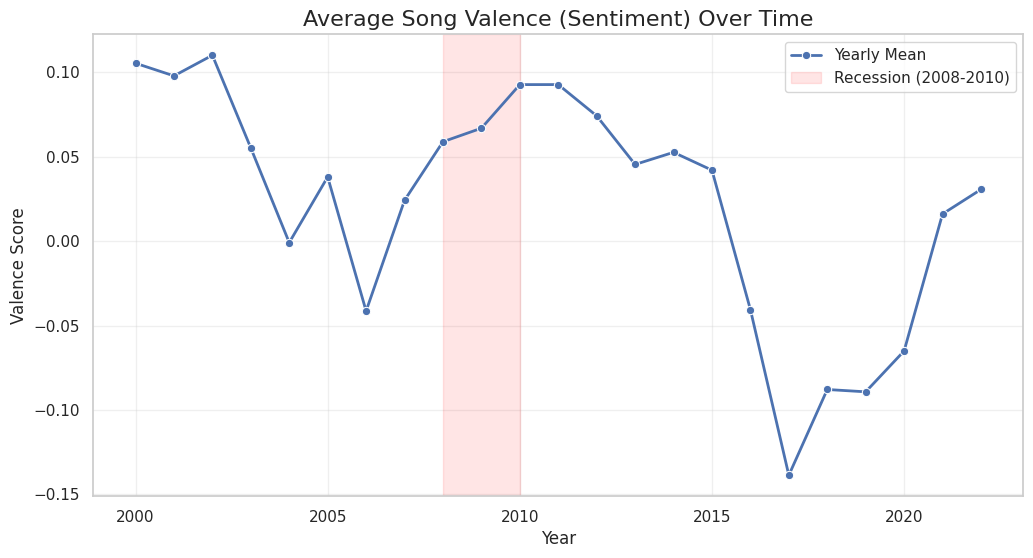

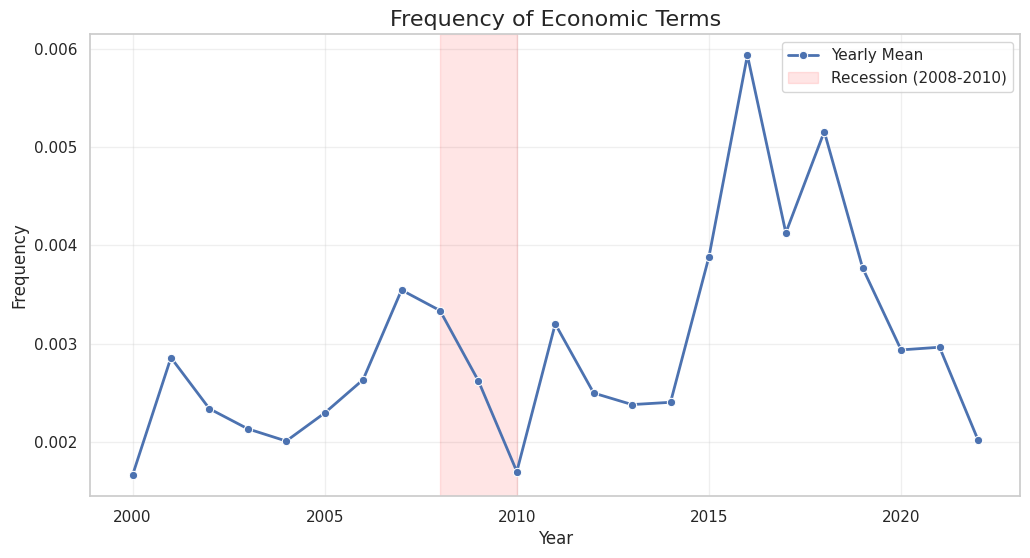

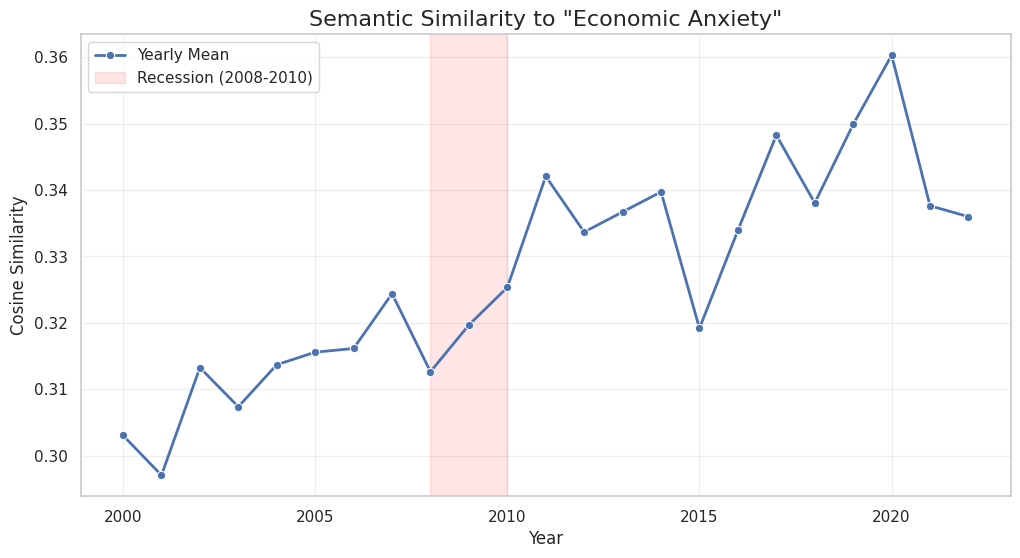

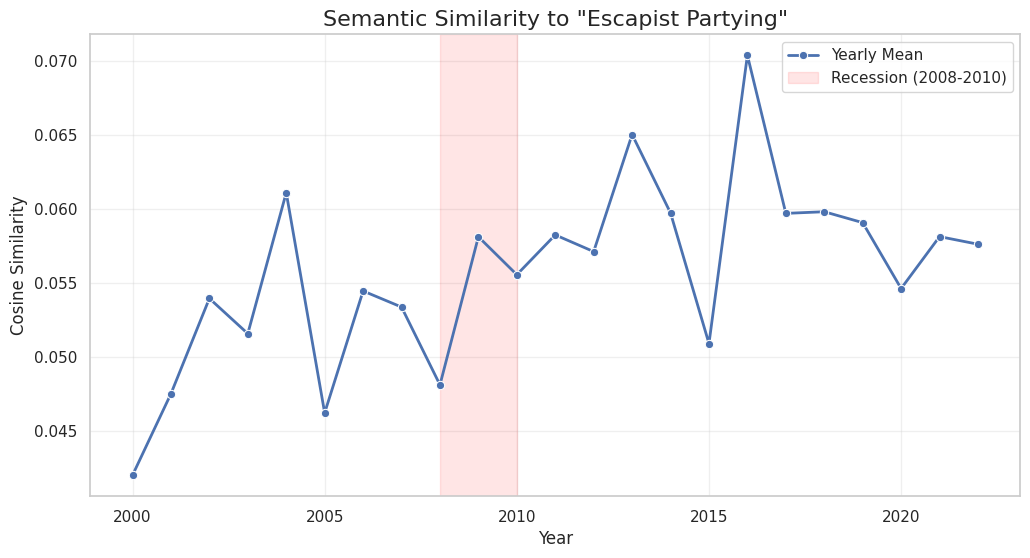

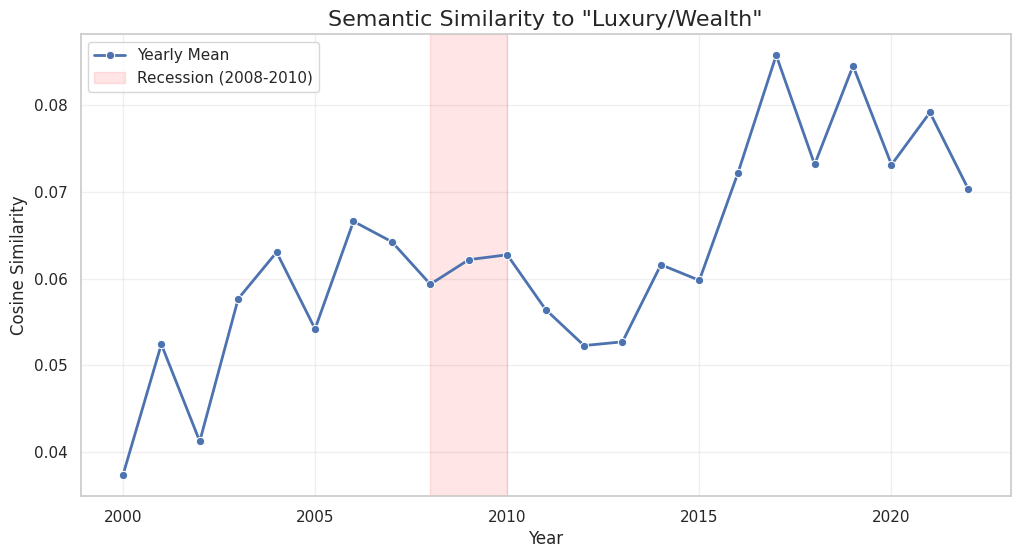

In [25]:
# 6. Visualize Feature Trends (2003–2015 Focus)

# Define periods for visualization
df['period'] = pd.cut(df['year'], 
                      bins=[1999, 2007, 2010, 2015, 2023], 
                      labels=['Pre-Recession', 'Recession', 'Post-Recession', 'Modern'])

# Aggregate by year
yearly_means = df.groupby('year').mean(numeric_only=True).reset_index()

# Plotting Function
def plot_trend(feature, title, ylabel):
    plt.figure(figsize=(12, 6))
    
    # Plot full trend
    sns.lineplot(data=yearly_means, x='year', y=feature, marker='o', linewidth=2, label='Yearly Mean')
    
    # Highlight Recession Window
    plt.axvspan(2008, 2010, color='red', alpha=0.1, label='Recession (2008-2010)')
    
    plt.title(title, fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Plot Key Features
plot_trend('valence_transformer', 'Average Song Valence (Sentiment) Over Time', 'Valence Score')
plot_trend('freq_economic', 'Frequency of Economic Terms', 'Frequency')
plot_trend('sim_econ_anxiety', 'Semantic Similarity to "Economic Anxiety"', 'Cosine Similarity')
plot_trend('sim_escapist_party', 'Semantic Similarity to "Escapist Partying"', 'Cosine Similarity')
plot_trend('sim_luxury_flex', 'Semantic Similarity to "Luxury/Wealth"', 'Cosine Similarity')

In [26]:
# Save Economic Frequency Data
# Saving song-level economic frequency and year to CSV
output_filename = "economic_frequency_data.csv"

if 'freq_economic' in df.columns and 'year' in df.columns:
    export_df = df[['year', 'freq_economic']].copy()
    export_df.to_csv(output_filename, index=False)
    print(f"Successfully saved {len(export_df)} rows to {output_filename}")
    print(export_df.head())
else:
    print("Error: Required columns 'year' or 'freq_economic' not found in dataframe.")

Successfully saved 2134 rows to economic_frequency_data.csv
      year  freq_economic
4585  2000       0.000000
4586  2000       0.000000
4587  2000       0.002463
4588  2000       0.002105
4589  2000       0.000000


In [27]:
# 7. Statistical Analysis: Detecting Shifts in the Recession Window

# Define Dummy Variables
df['is_recession'] = df['year'].apply(lambda x: 1 if 2008 <= x <= 2010 else 0)
df['is_post_recession'] = df['year'].apply(lambda x: 1 if 2011 <= x <= 2015 else 0)

# Function to run OLS
def run_recession_regression(target_col):
    # Formula: target ~ is_recession + is_post_recession + year + rank
    # We center 'year' to avoid multicollinearity issues or large numbers
    df['year_centered'] = df['year'] - 2008
    
    formula = f"{target_col} ~ is_recession + is_post_recession + year_centered + rank"
    model = smf.ols(formula=formula, data=df).fit()
    
    print(f"--- Regression Results for {target_col} ---")
    print(model.summary().tables[1])
    print("\n")
    return model

# Run for key features
key_features = ['valence_transformer', 'freq_economic', 'sim_econ_anxiety', 'sim_escapist_party', 'sim_luxury_flex']

for feature in key_features:
    run_recession_regression(feature)

--- Regression Results for valence_transformer ---
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0057      0.025      0.224      0.823      -0.044       0.055
is_recession          0.0596      0.035      1.686      0.092      -0.010       0.129
is_post_recession     0.0739      0.029      2.558      0.011       0.017       0.131
year_centered        -0.0063      0.002     -3.531      0.000      -0.010      -0.003
rank                  0.0003      0.000      0.642      0.521      -0.001       0.001


--- Regression Results for freq_economic ---
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0030      0.000      7.024      0.000       0.002       0.004
is_recession         -0.0004      0.001   

Training set size: 1202
Class distribution: label
0    923
1    279
Name: count, dtype: int64
Cross-Validation ROC-AUC: 0.516 (+/- 0.035)

--- Feature Importance (Logistic Regression Coefficients) ---
                Feature  Coefficient
9          avg_word_len     0.174628
13      sim_luxury_flex     0.109053
2          emotion_fear     0.107287
0   valence_transformer     0.101016
7         freq_negation     0.099395
3           emotion_joy     0.043429
12   sim_escapist_party     0.038772
4         freq_economic     0.032121
10     sim_econ_anxiety    -0.038858
5             freq_self    -0.043511
1       emotion_sadness    -0.048142
8                   ttr    -0.053559
6           freq_social    -0.113081
11       sim_resilience    -0.194515


/tmp/ipykernel_6035/1193069037.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x='Coefficient', y='Feature', palette='viridis')
/work/HalfdanNordahlFundal#2475/PENPAL_analysis/venv/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/work/HalfdanNordahlFundal#2475/PENPAL_analysis/venv/lib/python3.12/site-packages/seaborn/categorical.py:1273: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the 

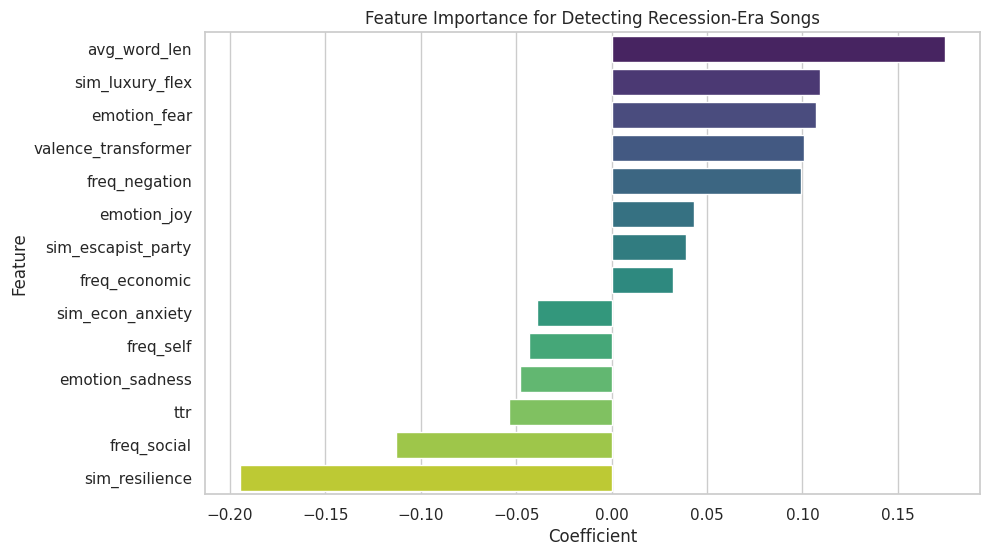

In [28]:
# 8. Train Recession-Era Classifier

# Define Labels
# 1 for 2008-2010, 0 for surrounding years (2003-2007 and 2011-2015)
# We filter the dataset to this window for training to avoid noise from very old or very new songs
train_window_df = df[(df['year'] >= 2003) & (df['year'] <= 2015)].copy()
train_window_df['label'] = train_window_df['year'].apply(lambda x: 1 if 2008 <= x <= 2010 else 0)

print(f"Training set size: {len(train_window_df)}")
print("Class distribution:", train_window_df['label'].value_counts())

# Select Features
features = [
    'valence_transformer', 
    'emotion_sadness', 'emotion_fear', 'emotion_joy',
    'freq_economic', 'freq_self', 'freq_social', 'freq_negation', 'ttr', 'avg_word_len',
    'sim_econ_anxiety', 'sim_resilience', 'sim_escapist_party', 'sim_luxury_flex'
]

X = train_window_df[features]
y = train_window_df['label']

# Standardize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Logistic Regression
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)
scores = cross_val_score(log_reg, X_scaled, y, cv=5, scoring='roc_auc')

print(f"Cross-Validation ROC-AUC: {scores.mean():.3f} (+/- {scores.std():.3f})")

# Fit on full training window
log_reg.fit(X_scaled, y)

# Inspect Coefficients
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\n--- Feature Importance (Logistic Regression Coefficients) ---")
print(coef_df)

# Visualize Coefficients
plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df, x='Coefficient', y='Feature', palette='viridis')
plt.title('Feature Importance for Detecting Recession-Era Songs')
plt.show()

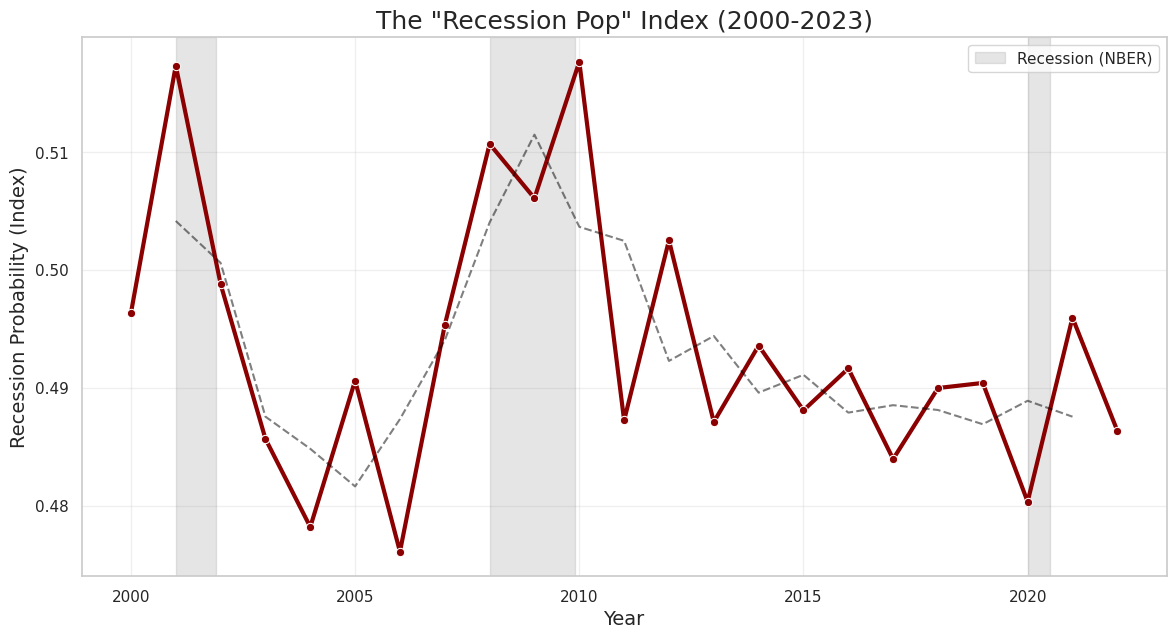

Recent Index Values:
    year  recession_prob  smoothed
18  2018        0.490021  0.488159
19  2019        0.490454  0.486953
20  2020        0.480383  0.488943
21  2021        0.495992  0.487593
22  2022        0.486404       NaN


In [29]:
# 9. Build and Monitor the Recession-Pop Index

# Apply to Full Dataset (1995-2023)
# We need to scale the full dataset features using the SAME scaler fitted on the training window
X_full = df[features]
X_full_scaled = scaler.transform(X_full)

# Predict Probabilities
df['recession_prob'] = log_reg.predict_proba(X_full_scaled)[:, 1]

# Create Index: Mean Probability per Year
recession_index = df.groupby('year')['recession_prob'].mean().reset_index()

# Plot Index
plt.figure(figsize=(14, 7))
sns.lineplot(data=recession_index, x='year', y='recession_prob', marker='o', linewidth=3, color='darkred')

# Highlight Recessions
# 2001 (Dot-com), 2008-2009 (Great Recession), 2020 (COVID)
plt.axvspan(2001, 2001.9, color='gray', alpha=0.2, label='Recession (NBER)')
plt.axvspan(2008, 2009.9, color='gray', alpha=0.2)
plt.axvspan(2020, 2020.5, color='gray', alpha=0.2)

plt.title('The "Recession Pop" Index (2000-2023)', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Recession Probability (Index)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Add smoothing
recession_index['smoothed'] = recession_index['recession_prob'].rolling(window=3, center=True).mean()
plt.plot(recession_index['year'], recession_index['smoothed'], linestyle='--', color='black', alpha=0.5, label='3-Year Moving Avg')

plt.show()

# Check recent years
recent = recession_index[recession_index['year'] >= 2018]
print("Recent Index Values:")
print(recent)